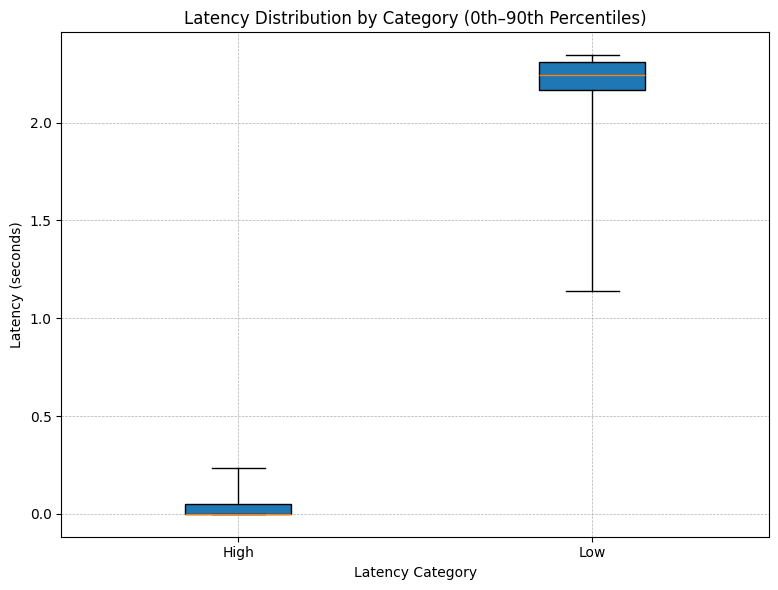

In [13]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

files = [
    ('latency_metrics_dispatcher_1.txt', 'D1'),
    ('latency_metrics_dispatcher_2.txt', 'D2'),
    ('latency_metrics_dispatcher_3.txt', 'D3')
]

upper_percentile = 90

data = []
for filename, dispatcher_label in files:
    with open(filename, 'r') as f:
        lines = f.readlines()
    for line in lines:
        match = re.search(r'Latency in (\S+): ([\d.]+) seconds', line)
        if match:
            latency = float(match.group(2))
            category = 'Low' if latency <= 0.5 else 'High'
            data.append({'latency': latency, 'category': category})

df = pd.DataFrame(data)
categories = ['Low', 'High']

label_swap = {'Low': 'High', 'High': 'Low'}

box_stats = []
for cat in categories:
    latencies = df[df['category'] == cat]['latency'].values
    if len(latencies) == 0:
        continue
    stats = {
        'label': label_swap[cat],   # Swap labels here
        'med': np.percentile(latencies, 50),
        'q1': np.percentile(latencies, 25),
        'q3': np.percentile(latencies, 75),
        'whislo': np.percentile(latencies, 0),
        'whishi': np.percentile(latencies, upper_percentile),
        'fliers': []
    }
    box_stats.append(stats)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f"Latency Distribution by Category (0th–{upper_percentile}th Percentiles)")
ax.set_xlabel("Latency Category")
ax.set_ylabel("Latency (seconds)")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

ax.bxp(box_stats, showfliers=False, patch_artist=True, widths=0.3)
plt.show()


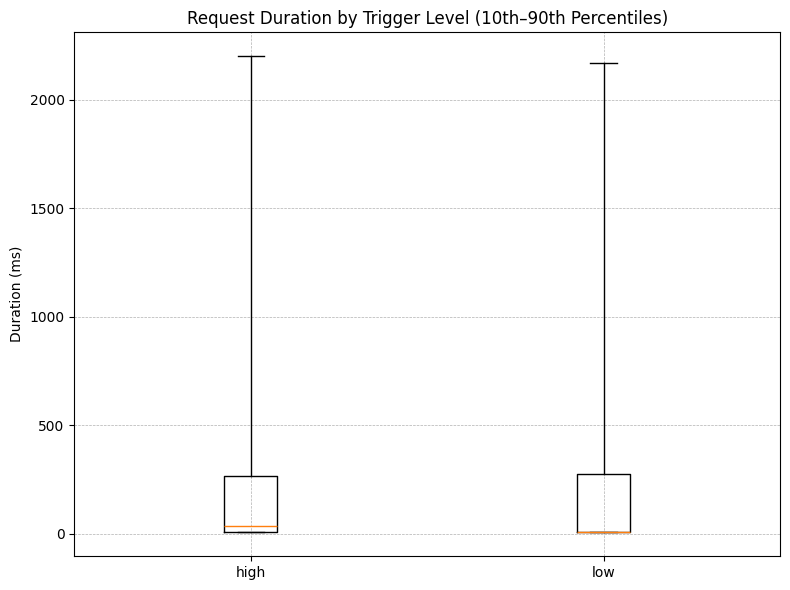

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your JSON file
with open("traces-1753433183127.json") as f:
    trace_data = json.load(f)

trace_timings = []

# Extract duration and trigger level
for trace in trace_data["data"]:
    trace_id = trace["traceID"]
    start_times = []
    end_times = []
    trigger_level = None

    for span in trace["spans"]:
        start = span["startTime"]
        duration = span["duration"]
        end = start + duration
        start_times.append(start)
        end_times.append(end)

        for tag in span.get("tags", []):
            if tag["key"] == "trigger.level":
                trigger_level = tag["value"]

    if start_times and end_times:
        total_duration_us = max(end_times) - min(start_times)
        total_duration_ms = total_duration_us / 1000
        trace_timings.append({
            "trace_id": trace_id,
            "duration_ms": total_duration_ms,
            "trigger_level": trigger_level or "unknown"
        })

# Convert to DataFrame
df = pd.DataFrame(trace_timings)

# Optional label swap
label_map = {"high": "low", "low": "high", "unknown": "unknown"}

# Get unique trigger levels
levels = df["trigger_level"].unique()

# Prepare custom boxplot stats with swapped labels
box_data = []
for lvl in levels:
    durations = df[df["trigger_level"] == lvl]["duration_ms"].values
    stats = {
        'label': label_map.get(lvl, lvl),  # Swap label here
        'whislo': np.percentile(durations, 10),  # 10th percentile
        'q1':     np.percentile(durations, 25),
        'med':    np.percentile(durations, 50),
        'q3':     np.percentile(durations, 75),
        'whishi': np.percentile(durations, 90),  # 90th percentile
        'fliers': []  # No outliers
    }
    box_data.append(stats)

# Plot using matplotlib’s low-level function
fig, ax = plt.subplots(figsize=(8, 6))
ax.bxp(box_data, showfliers=False)  # No need to reverse if just swapping labels

ax.set_title("Request Duration by Trigger Level (10th–90th Percentiles)")
ax.set_ylabel("Duration (ms)")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
